In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import numpy as np
from random import random, uniform, randrange, triangular
from tqdm import tqdm

In [2]:
#Pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
import os
files = os.listdir("dataset")

import csv
cv = []
class Route:
    def __init__(self, phi, v, M, IMU_v, IMU_alpha):
        self.phi = phi
        self.v = v
        self.M = M
        self.IMU_v = IMU_v
        self.IMU_alpha = IMU_alpha
    def __len__(self):
        return len(self.phi)
    
routes = []

allRows = 0

maxAngle = 0
maxSpeed = 0
maxTorque = 0

maxVDot = [0]*3
maxAlphaDot = [0]*3
for file in files:
    path = os.path.join("dataset", file)
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ')
        phi = []
        v = []
        M = []
        IMU_v = []
        IMU_alpha = []
        for row in spamreader:
            phi.append(float(row[1]))
            v.append(float(row[2]))
            cv.append(float(row[2]))
            M.append(float(row[3]))
            
            vPacket = [float(row[i]) for i in range(4, 7)]
            alphaPacket = [float(row[i]) for i in range(7, 10)]
            IMU_v.append(vPacket)
            IMU_alpha.append(alphaPacket)
            
            maxAngle = max(abs(float(row[1])), maxAngle)
            maxSpeed = max(abs(float(row[2])), maxSpeed)
            maxTorque = max(abs(float(row[3])), maxTorque)
            
            for i in range(3):
                maxVDot[i] = max(abs(float(row[4+i])), maxVDot[i])
                maxAlphaDot[i] = max(abs(float(row[7+i])), maxAlphaDot[i])
        if min(v) > 25:
            routes.append(Route(torch.tensor(phi), torch.tensor(v), torch.tensor(M), torch.tensor(IMU_v).permute(1,0), torch.tensor(IMU_alpha).permute(1,0)))
            allRows += len(phi)


print(allRows)
print(maxAngle, maxSpeed, maxTorque, maxVDot, maxAlphaDot)

491822
41.70000076293945 39.09857177734375 1.0 [19.161849975585938, 8.428146362304688, 11.452590942382812] [0.18414306640625, 0.8147430419921875, 0.1421051025390625]


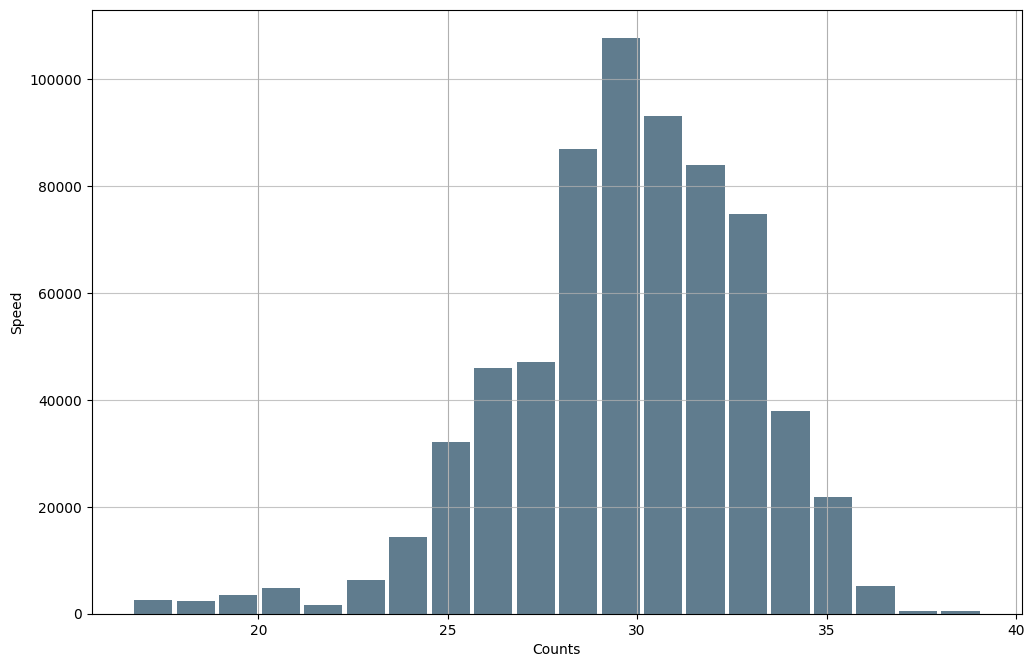

In [4]:
import pandas as pd

size, scale = 1000, 10
commutes = pd.Series(np.array(cv))

commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.xlabel('Counts')
plt.ylabel('Speed')
plt.grid(axis='y', alpha=0.75)

In [11]:
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

#PLAN: Model dobi phi, v in IMU, ter phi v nekaj tockah
# v prihodnosti in mora izracunati potreben navor 
# da se doseze tisti kot
    
    
prev_data = 100

group_phi_fut = 20
fwd_data = [group_phi_fut*i for i in range(1, 4)]
M_prev_len = 50

all_routes = len(routes)
print(f"{all_routes} routes")
test_count = int(all_routes*0.2)
# test_routes_id = [randrange(all_routes) for _ in range(test_count)]
test_routes_id = [33, 58, 17, 45, 47, 59, 9, 17, 44, 16, 8, 29]

train_routes = [routes[i] for i in range(all_routes) if i not in test_routes_id]
test_routes = [routes[i] for i in range(all_routes) if i in test_routes_id]
#Phi, v, IMU_v, IMU_alpha
groups = [1, 10, 4, 4]

input_length = prev_data//groups[0] + prev_data//groups[1] + 3*prev_data//groups[2] + 3*prev_data//groups[3] + 1 +len(fwd_data)
output_length = len(fwd_data)

def caddy_dataset(train):
    i_data = []
    o_data = []
    routes = train_routes if train else test_routes
    for route in tqdm(routes):
        for idx in range(prev_data, len(route.v)-fwd_data[-1], 5):
            phi = route.phi[idx-prev_data : idx]/maxAngle
            phi_fut = torch.tensor([route.phi[idx+shift]/maxAngle for shift in fwd_data])
            v = route.v[idx-prev_data : idx]/maxSpeed
            M = route.M[idx - M_prev_len : idx]/maxTorque
            M_fut = route.M[idx : idx + fwd_data[-1]]/maxTorque
#             print(phi*maxAngle, end="\n------\n")
#             print(phi_fut*maxAngle, end="\n------\n")
#             print(route.M[idx], M_fut, end="\n------\n")
            
            phi = phi.reshape(-1, groups[0]).mean(axis=1)
            v = v.reshape(-1, groups[1]).mean(axis=1)
            M = M.reshape(-1, M_prev_len).mean(axis=1)
            M_fut = M_fut.reshape(-1, group_phi_fut).mean(axis=1)
#             print(phi*maxAngle, end="\n------\n")
#             print(phi_fut*maxAngle, end="\n------\n")
            
            IMU_v = [(route.IMU_v[i][idx-prev_data:idx]/maxVDot[i]).reshape(-1, groups[2]).mean(axis=1) for i in range(3)]
            IMU_alpha = [(route.IMU_alpha[i][idx-prev_data:idx]/maxAlphaDot[i]).reshape(-1, groups[3]).mean(axis=1) for i in range(3)]
            
            o = torch.zeros((output_length,))
            for i in range(output_length):
                o[i] = M_fut[i]
#             print(o)
            data = (phi, v, IMU_v[0], IMU_v[1], IMU_v[2], IMU_alpha[0], IMU_alpha[1], IMU_alpha[2], M, phi_fut)
            data_input = np.concatenate(data)
            i_data.append(data_input)
            o_data.append(o)
#             return []
    return SimDataset(len(i_data), i_data, o_data)


train_set = caddy_dataset(True)
test_set = caddy_dataset(False)

print(len(train_set), len(test_set), test_routes_id)

  2%|▏         | 1/51 [00:00<00:08,  5.84it/s]

62 routes


100%|██████████| 11/11 [00:02<00:00,  3.82it/s]

86609 9797 [33, 58, 17, 45, 47, 59, 9, 17, 44, 16, 8, 29]


In [25]:
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=False)
print(len(train_dataloader))
print(len(test_dataloader))

1353
154


In [26]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_length, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_length),
            nn.Tanh()
        )

        
    def forward(self, x):
        return self.linear_relu_stack(x)
print(input_length)

264


In [28]:
def train_loop(dataloader, model, loss_fn, optimizer, debug):
    size = len(dataloader.dataset)
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if debug:
        loss = loss.item()
        print(f"Train loss: {loss}")
    return loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test  loss: {test_loss} \n")
    return test_loss

model = NeuralNetwork()
for p in model.parameters():
    print(p.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

torch.Size([64, 264])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([3, 32])
torch.Size([3])
23299


Epoch 0
Train loss: 0.013903838582336903
Test  loss: 0.013373391960547971 

Epoch 1
Train loss: 0.010630909353494644
Test  loss: 0.013181933164808222 

Epoch 2
Train loss: 0.01880858652293682
Test  loss: 0.01299825041893531 

Epoch 3
Train loss: 0.01824740134179592
Test  loss: 0.013110169511161406 

Epoch 4
Train loss: 0.017275238409638405
Test  loss: 0.013164061578988497 

Epoch 5
Train loss: 0.021853746846318245
Test  loss: 0.012931392167531582 

Epoch 6
Train loss: 0.010939926840364933
Test  loss: 0.013023202261409735 

Epoch 7
Train loss: 0.009301143698394299
Test  loss: 0.013017809521195224 

Epoch 8
Train loss: 0.011791377328336239
Test  loss: 0.013098108015996828 

Epoch 9
Train loss: 0.007596844807267189
Test  loss: 0.012970787395916686 

Epoch 10
Train loss: 0.010285809636116028
Test  loss: 0.012993078604007937 

Epoch 11
Train loss: 0.018455637618899345
Test  loss: 0.012837387789978174 

Epoch 12
Train loss: 0.014873695559799671
Test  loss: 0.013030926882162352 

Epoch 13
Tra

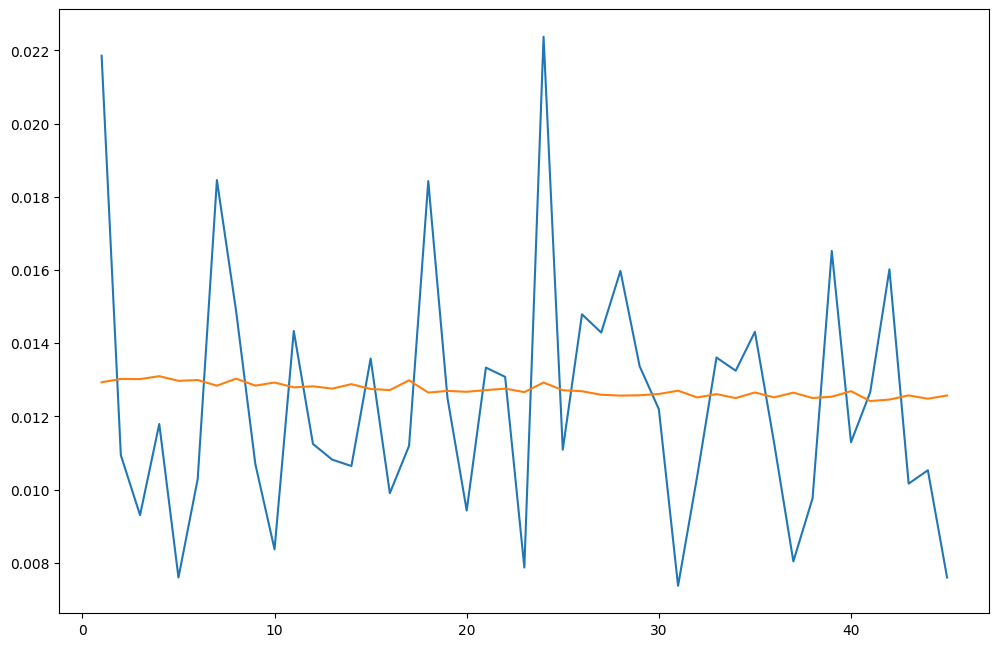

In [41]:
epochs = 50
skip = 1
loss_t = []
loss_e = []
for t in range(epochs):
    if t%skip == 0:
        print(f"Epoch {t}")
    loss_t.append(train_loop(train_dataloader, model, loss_fn, optimizer, t%skip==0))
    if t%skip == 0:
        loss_e.append(test_loop(test_dataloader, model, loss_fn))

plt_skip = 5

plt.plot(np.linspace(1, epochs-plt_skip, epochs-plt_skip), loss_t[plt_skip:])
plt.plot(np.linspace(1, epochs-plt_skip, epochs-plt_skip), loss_e[plt_skip:])

tensor([-0.4637, -0.4478, -0.4189], grad_fn=<MulBackward0>)


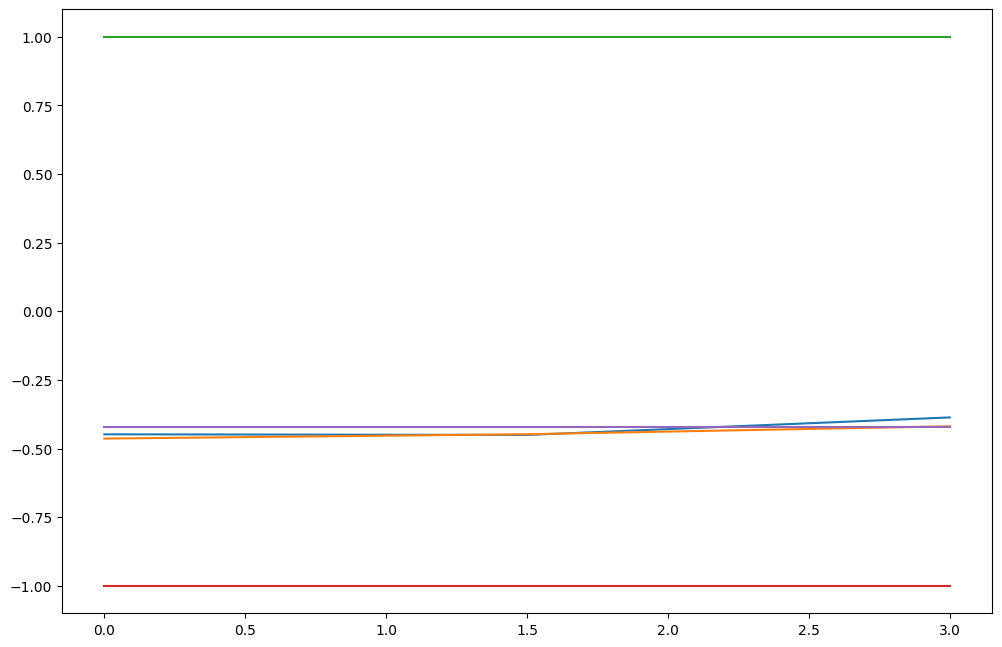

In [61]:
random_sample = test_set[randrange(len(test_set))]
data_input = random_sample[0]
init_M = data_input[-len(fwd_data)-1]
torch_data_input = torch.from_numpy(data_input)
torch_data_output = model(torch_data_input)

print(torch_data_output*maxTorque)

ls_good = [random_sample[1][i]*maxTorque for i in range(output_length)]
ls_pred = [torch_data_output[i]*maxTorque for i in range(output_length)]

plt.plot(np.linspace(0, output_length, output_length), ls_good)
plt.plot(np.linspace(0, output_length, output_length), ls_pred)
plt.plot(np.linspace(0, output_length, output_length), np.ones((output_length,)))
plt.plot(np.linspace(0, output_length, output_length), np.ones((output_length,))*-1)
plt.plot(np.linspace(0, output_length, output_length), np.ones((output_length,))*init_M)

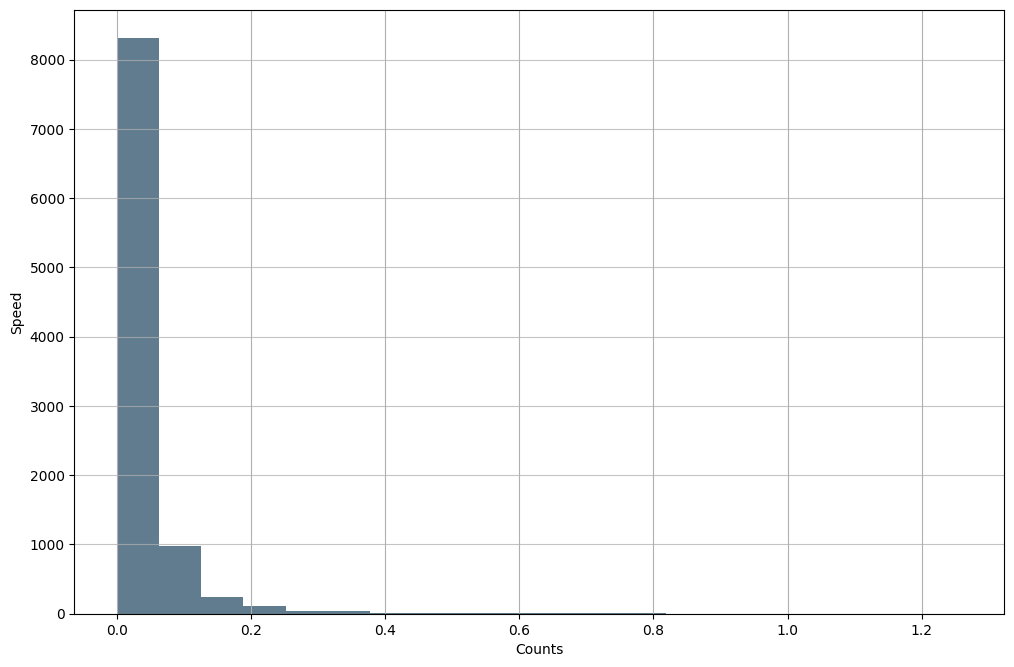

In [47]:
lshape = []
for random_sample in test_set:

    data_input = random_sample[0]
    torch_data_input = torch.from_numpy(data_input)
    torch_data_output = model(torch_data_input)


    ls_good = [random_sample[1][i]*maxTorque for i in range(output_length)]
    ls_pred = [torch_data_output[i]*maxTorque for i in range(output_length)]
    mse = sum([(ls_good[i].item()-ls_pred[i].item())**2 for i in range(output_length)])
    lshape.append(mse)
size, scale = 1000, 20
commutes = pd.Series(np.array(lshape))

commutes.plot.hist(grid=True, bins=20, color='#607c8e')
plt.xlabel('Counts')
plt.ylabel('Speed')
plt.grid(axis='y', alpha=0.75)

In [62]:
good = 0
bad = 0
for random_sample in test_set:

    data_input = random_sample[0]
    init_M = data_input[-len(fwd_data)-1]
    torch_data_input = torch.from_numpy(data_input)
    torch_data_output = model(torch_data_input)


    ls_good = [random_sample[1][i]*maxTorque for i in range(output_length)]
    ls_pred = [torch_data_output[i]*maxTorque for i in range(output_length)]
    if ls_good[0]<init_M and ls_pred[0] < init_M:
        good+=1
    elif ls_good[0]>init_M and ls_pred[0] > init_M:
        good+=1
    else:
        bad+=1
print(good, bad)

6926 2871


In [63]:
torch.save(model, 'model_M.pth')